Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [3]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [4]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

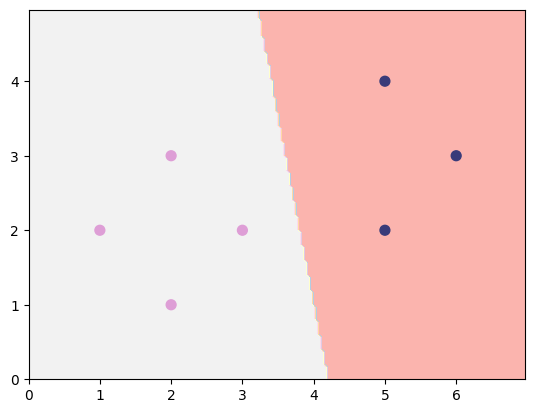

In [5]:
clf = RidgeClassifier(alpha=0).fit(seven_X, seven_y)

plot_2d_clf_problem(seven_X, seven_y, clf.predict)



Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

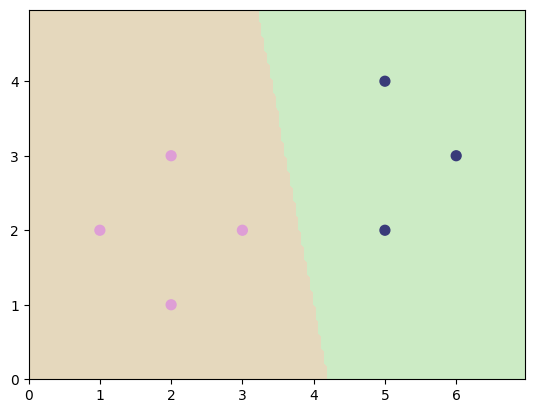

In [6]:
reg = LinearRegression().fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, lambda x : reg.predict(x) >= 0.5)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [7]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

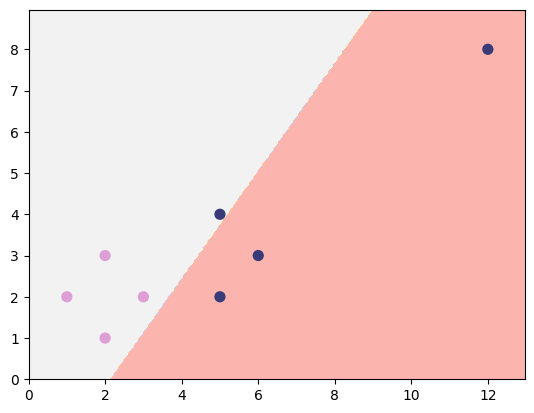

In [8]:
clf = RidgeClassifier(alpha=0).fit(outlier_X, outlier_y)

plot_2d_clf_problem(outlier_X, outlier_y, clf.predict)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [9]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

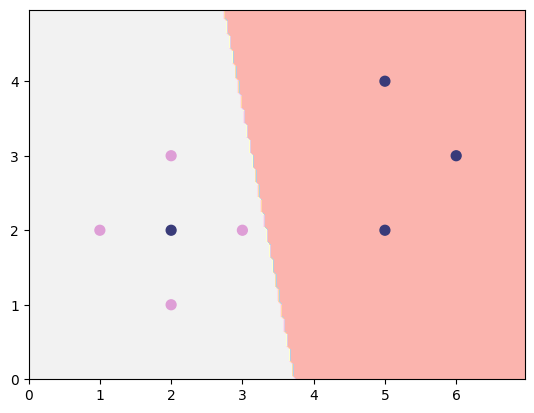

In [10]:
clf = RidgeClassifier(alpha=0).fit(unsep_X, unsep_y)

plot_2d_clf_problem(unsep_X, unsep_y, clf.predict)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

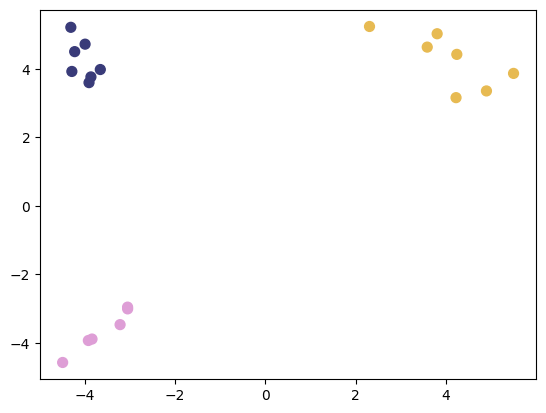

In [11]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=20, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=3, class_sep=4.0, n_clusters_per_class=1)

plot_2d_clf_problem(X, y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

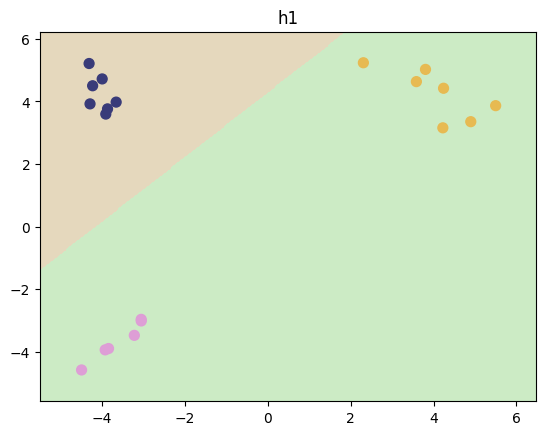

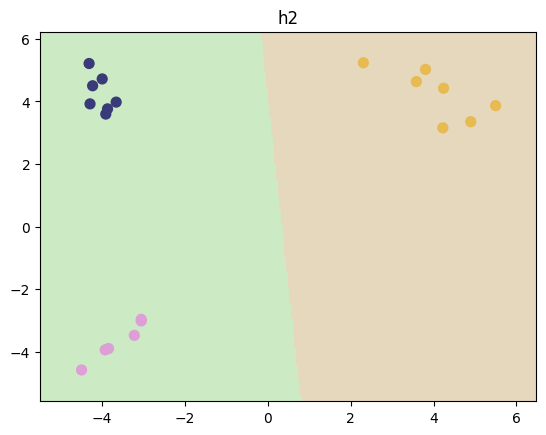

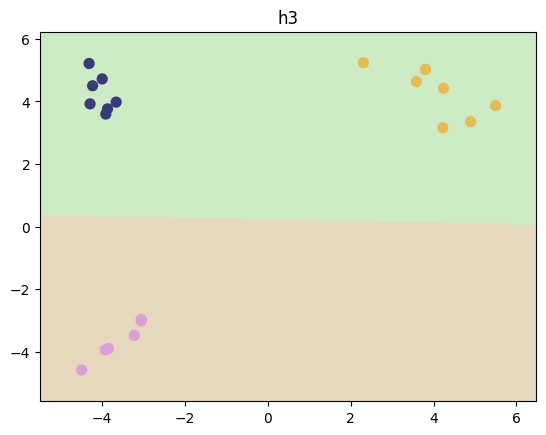

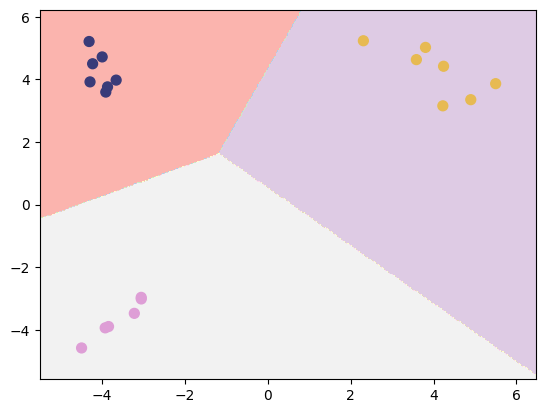

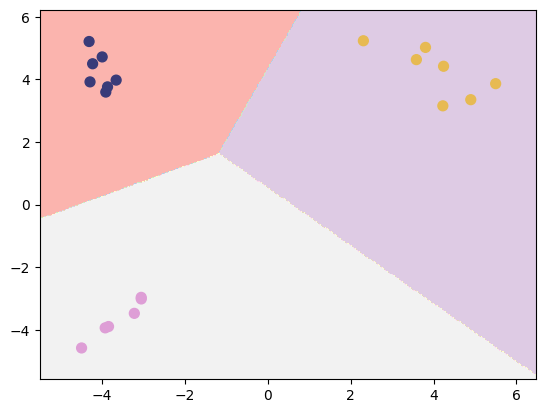

In [12]:

y12 = np.copy(y)
y23 = np.copy(y)
y13 = np.copy(y)

y12[y12 == 1] = 0
y12[y12 == 2] = 1

y23[y23 == 1] = 2
y23[y23 == 0] = 1
y23[y23 == 2] = 0

y13[y13 == 2] = 0


h1 = LinearRegression().fit(X, y23)
h2 = LinearRegression().fit(X, y13)
h3 = LinearRegression().fit(X, y12)

def predict_ovr(X):

    h1_pred = h1.predict(X)
    h2_pred = h2.predict(X)
    h3_pred = h3.predict(X)

    

    preds = np.array([h1_pred, h2_pred, h3_pred])

    res = []

    
    for j in range(len(h1_pred)):
        max = -np.inf
        max_i = 0

        for i in range(len(preds)):
            if preds[i][j] > max:
                max = preds[i][j]
                max_i = i

        res += [max_i]

    res = np.array(res)
    res =  res[:, np.newaxis]
    return res

plot_2d_clf_problem(X, y, lambda x : h1.predict(x) > 0.5)
plt.title("h1")
plt.show()
plot_2d_clf_problem(X, y, lambda x : h2.predict(x) > 0.5)
plt.title("h2")
plt.show()
plot_2d_clf_problem(X, y, lambda x : h3.predict(x) > 0.5)
plt.title("h3")

plt.show()



plot_2d_clf_problem(X, y, predict_ovr)
plt.show()

clf = RidgeClassifier(alpha=0)

clf.fit(X, y)
plot_2d_clf_problem(X, y, clf.predict)


### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

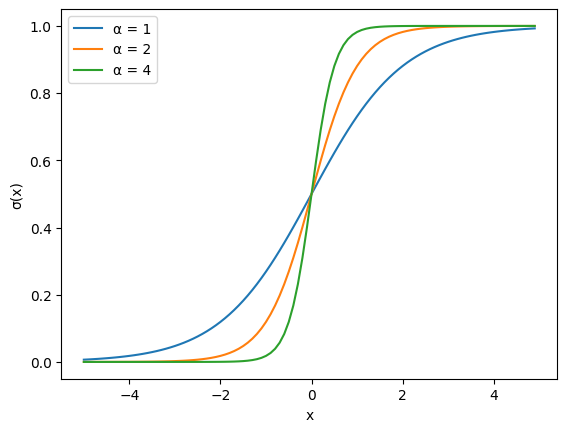

In [13]:
def sigm(x, alpha=1):
    return 1 / (1 + np.exp(-alpha * x))

x_os = np.arange(-5, 5, 0.1)
y_os_1 = [sigm(x, 1) for x in x_os]
y_os_2 = [sigm(x, 2) for x in x_os]
y_os_4 = [sigm(x, 4) for x in x_os]

plt.plot(x_os, y_os_1, label="α = 1")
plt.plot(x_os, y_os_2, label="α = 2")
plt.plot(x_os, y_os_4, label="α = 4")

plt.legend()
plt.xlabel("x")
plt.ylabel("σ(x)")

plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [14]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

def lr_h(x, w):
    return sigm(np.dot(x, w))

def cross_entropy_error(X, y, w, alpha=0):
    err = alpha/2 * np.dot(w, w)

    for i in range(len(y)):
        if lr_h(X[i], w) in {0, 1}:
            return np.inf
        
        err += (-y[i] * np.log(lr_h(X[i], w)) - (1 - y[i]) * np.log(1 - lr_h(X[i], w)))
    return 1/len(y) * err

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    n = len(X[0])
    
    X = PolynomialFeatures(1).fit_transform(X)

    w = np.zeros(n + 1)
    W = [w]

    iter = 0
    cee_prev = np.inf
    cee = cross_entropy_error(X, y, w, alpha)
    while abs(cee_prev - cee) > epsilon and iter < max_iter:
        iter += 1
        delta_w = np.zeros(n + 1)

        for i in range(len(X)):
            h = lr_h(w, X[i])
            delta_w = delta_w - (h - y[i])*X[i]
        
        w0_save = w[0] + eta * delta_w[0]

        w = (1 - eta * alpha) * w + eta * delta_w
        
        w[0] = w0_save

        W += [w]

        cee_prev = cee
        cee = cross_entropy_error(X, y, w, alpha)

    print("iter =", iter)
    if trace:
        return w, W
    
    return w


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [15]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

iter = 947


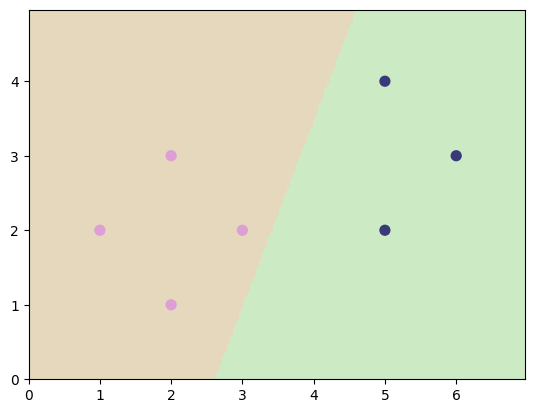

In [16]:
def lr_predict(X, w):
    FI = PolynomialFeatures(1).fit_transform(X)
    res = []
    for x in FI:
        res += [lr_h(x, w)]
    res = np.array(res)
    return res


w = lr_train(seven_X, seven_y)


plot_2d_clf_problem(seven_X, seven_y, lambda x : lr_predict(x, w) > 0.5)


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [17]:
from sklearn.metrics import zero_one_loss

iter = 947


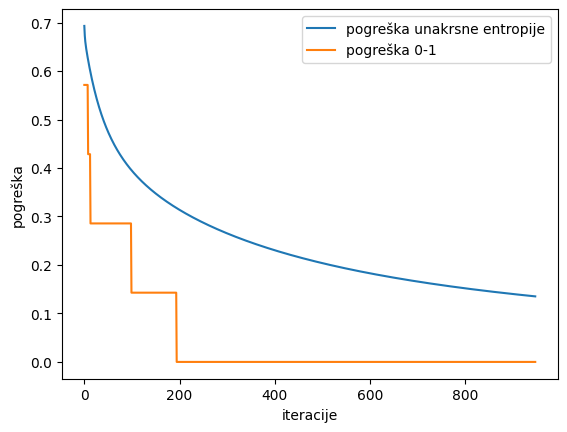

iter = 1142
iter = 947
iter = 511
iter = 378


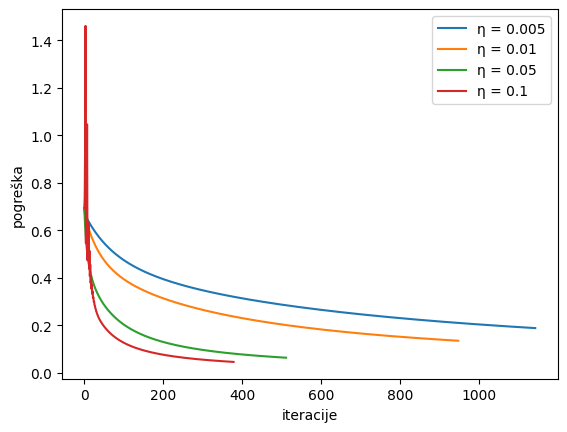

In [18]:
w_ignore, Ws = lr_train(seven_X, seven_y, trace=True)

cee = []
zol = []
iters = range(len(Ws))
X = PolynomialFeatures(1).fit_transform(seven_X)
for w in Ws:
    cee += [cross_entropy_error(X, seven_y, w)]
    zol += [zero_one_loss(lr_h(X, w) > 0.5, seven_y)]

plt.plot(iters, cee, label="pogreška unakrsne entropije")
plt.plot(iters, zol, label="pogreška 0-1")
plt.xlabel("iteracije")
plt.ylabel("pogreška")

plt.legend()
plt.show()

etas = [0.005, 0.01, 0.05, 0.1]

for eta in etas:
    w_ignore, Ws = lr_train(seven_X, seven_y, eta=eta, trace=True)
    iters = range(len(Ws))
    cee = []
    for w in Ws:
        cee += [cross_entropy_error(X, seven_y, w)]

    plt.plot(iters, cee, label="η = " + str(eta))

plt.legend()
plt.xlabel("iteracije")
plt.ylabel("pogreška")
plt.show()






**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

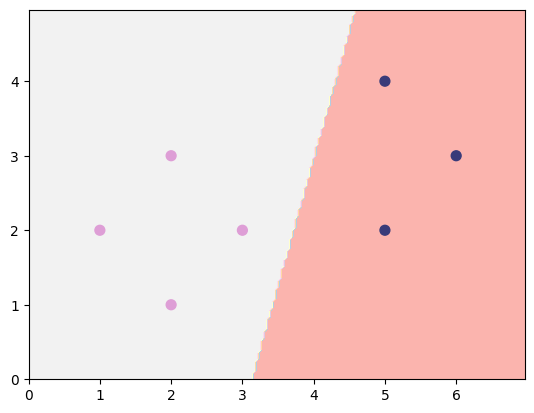

In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(tol=0.0001, C=np.inf, max_iter=2000).fit(seven_X, seven_y)

plot_2d_clf_problem(seven_X, seven_y, clf.predict)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [20]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

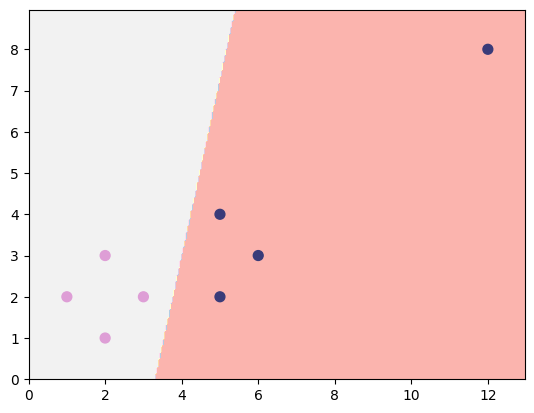

In [21]:
clf = LogisticRegression(tol=0.0001, C=np.inf, max_iter=2000).fit(outlier_X, outlier_y)

plot_2d_clf_problem(outlier_X, outlier_y, clf.predict)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

iter = 947


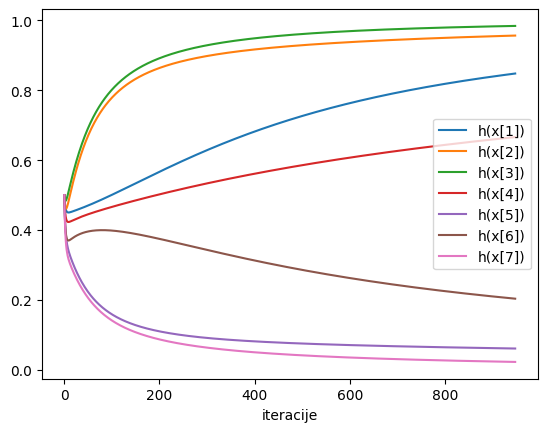

[ 4.45449454 -1.71089242  0.68413507]


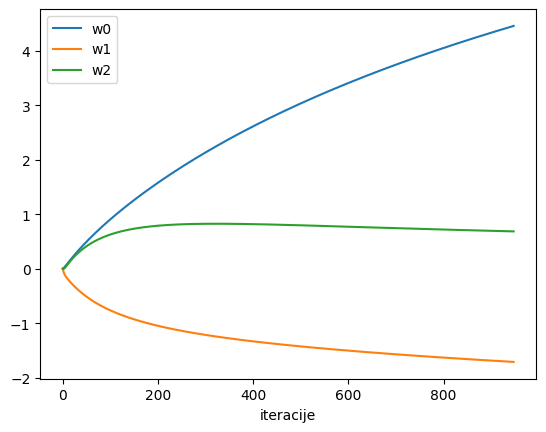

In [22]:
w_ignore, Ws = lr_train(seven_X, seven_y, trace=True)

iter = range(len(Ws))

h = [[] for i in range(len(seven_X))]

X = PolynomialFeatures(1).fit_transform(seven_X)

for w in Ws:
    for i in range(len(X)):
        h[i] += [lr_h(X[i], w)]

for i in range(len(X)):
    plt.plot(iter, h[i], label="h(x[" + str(i + 1) + "])")

plt.xlabel("iteracije")
plt.legend()
plt.show()

w_iters = [[] for i in range(len(w_ignore))]
for w in Ws:
    for i in range(len(w)):
        w_iters[i] += [w[i]]
print(w_ignore)
for i in range(len(w_ignore)):
    plt.plot(iter, w_iters[i], label="w" + str(i))

plt.xlabel("iteracije")
plt.legend()
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [23]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

iter = 454


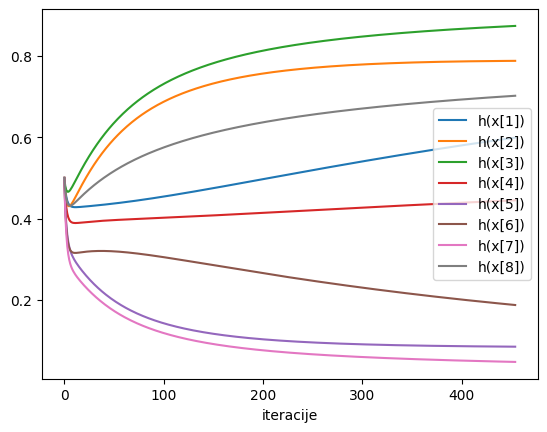

[ 2.10352878 -1.0785606   0.45549163]


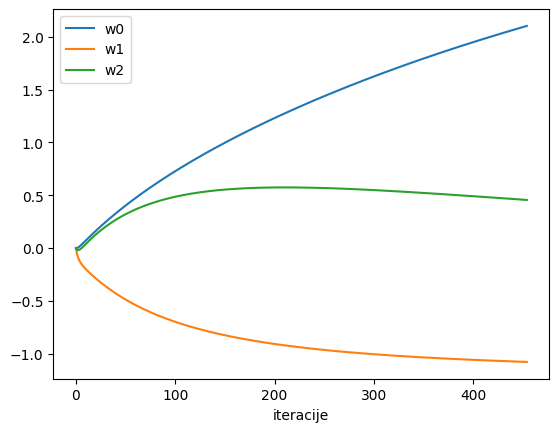

In [24]:
w_ignore, Ws = lr_train(unsep_X, unsep_y, trace=True)

iter = range(len(Ws))

h = [[] for i in range(len(unsep_X))]

X = PolynomialFeatures(1).fit_transform(unsep_X)

for w in Ws:
    for i in range(len(X)):
        h[i] += [lr_h(X[i], w)]

for i in range(len(X)):
    plt.plot(iter, h[i], label="h(x[" + str(i + 1) + "])")

plt.legend()
plt.xlabel("iteracije")
plt.show()

w_iters = [[] for i in range(len(w_ignore))]
for w in Ws:
    for i in range(len(w)):
        w_iters[i] += [w[i]]
print(w_ignore)
for i in range(len(w_ignore)):
    plt.plot(iter, w_iters[i], label="w" + str(i))

plt.legend()
plt.xlabel("iteracije")
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [25]:
from numpy.linalg import norm

iter = 947
iter = 86
iter = 13
iter = 467


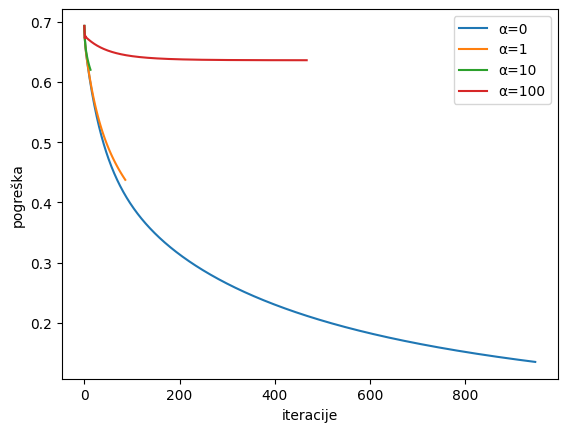

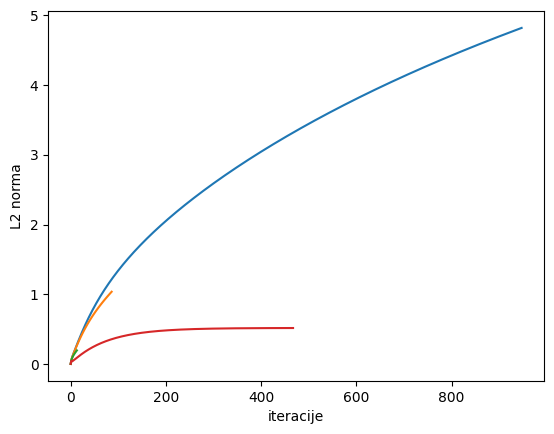

In [26]:
alphas = [0, 1, 10, 100]
X = PolynomialFeatures(1).fit_transform(seven_X)

cee = [[], [], [], []]
l2 = [[], [], [], []]

iters = range(2722)
for i in range(len(alphas)):
    alpha = alphas[i]
    w_ignore, Ws = lr_train(seven_X, seven_y, trace=True, alpha=alpha)
    for w in Ws:
        cee[i] += [cross_entropy_error(X, seven_y, w)]
        l2[i] += [norm(w)]

for i in range(4):
    plt.plot(range(len(cee[i])), cee[i], label="α=" + str(alphas[i]))

plt.xlabel("iteracije")
plt.ylabel("pogreška")
plt.legend()
plt.show()

for i in range(4):
    plt.plot(range(len(l2[i])), l2[i], label="α=" + str(alphas[i]))

plt.xlabel("iteracije")
plt.ylabel("L2 norma")

plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [27]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

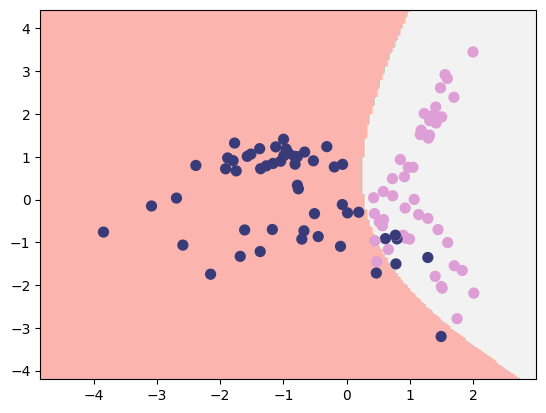

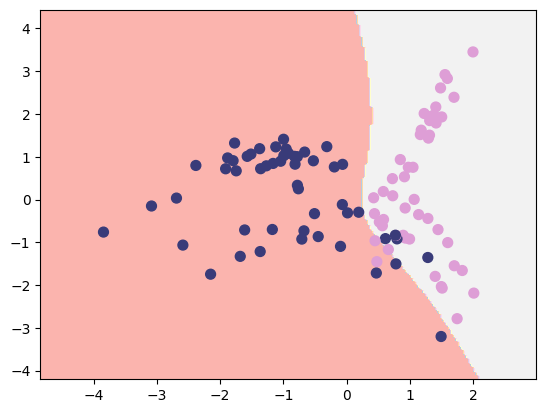

In [29]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2)


poly = PolynomialFeatures(2)

model = LogisticRegression(max_iter=2000).fit(poly.fit_transform(X), y)

plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x)))
plt.show()



poly = PolynomialFeatures(3)

model = LogisticRegression(max_iter=2000).fit(poly.fit_transform(X), y)

plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x)))
plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?